# DSGRN Python Interface Tutorial 
This notebook shows the basics of manipulating DSGRN with the python interface. We use repressilator with an extra edge as an example and search for periodic behavior and bistabilty.

In [1]:
import DSGRN

## Network
The starting point of the DSGRN analysis is a network specification file. I have created  a network specification file "br.txt" that specifies bistable repressilator. We first will load it in.

In [2]:
br = DSGRN.Network("br.txt")

We would like to see the network in the way that it is specified in the file br.txt

In [3]:
print(br)

## Graphviz
Many of the objects in DSGRN provide a method "graphviz" which emits a string understood by the graphviz language. In an iPython notebook we can embed these pictures easily. To visualize all the graphs below we will use the python package graphviz.

In [4]:
import graphviz

DSGRN created an object br with a method "graphviz" that produces a file in graphviz format. Here it is. 

In [5]:
print(br.graphviz())

digraph {
bgcolor = aliceblue;"X0" [style=filled fillcolor=beige];
"X1" [style=filled fillcolor=beige];
"X2" [style=filled fillcolor=beige];
"X2" -> "X0" [color=black arrowhead="tee"];
"X1" -> "X0" [color=darkgoldenrod arrowhead="tee"];
"X0" -> "X1" [color=black arrowhead="normal"];
"X1" -> "X2" [color=black arrowhead="normal"];
}



To actually see the picture we export and then look at it:

In [6]:
graph = graphviz.Source(br.graphviz())

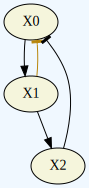

In [7]:
graph

## ParameterGraph
For each network, there is an associated "Parameter Graph", which is a combinatorial representation of parameter space.

In [8]:
br_pg = DSGRN.ParameterGraph(br)

The size of the parameter graph is an important number that grows quickly with the size of the network. This is the number of the distinct domains in the parameter space such that the Morse graph is constant in each domain.

In [9]:
print(br_pg.size())

216


## Computing Database of all Morse graphs for entire parameter graph
For this task we need to open a Terminal and compute the database using command line arguments. This is the essential part of the analysis using DSGRN. It allows us to concentrate on the dynamics we want to observe using SQL searches for dynamic signatures like periodicity, bistability and fixed points with particular vector annotations.

Go back to the notebooks/tutorial tab. Under "New", click Terminal. This logs you into a remote computer with your own home directory that was set up specifically for this workshop. DSGRN software is installed on this machine. The name of the program that constructs the database is called Signatures. The following command runs Signatures in parallel on 4 processors. We need to supply the network file name and a file name for the database. Copy and paste it into your Terminal tab, then press Enter.

~~~~
mpiexec -np 4 Signatures notebooks/Tutorials/br.txt br.db
~~~~

The execution is very fast for small networks, but may take some time for larger networks. 
  
For this network, the database is very small and we can look at it by eye, and we will shortly. But in general the databases are very large. In that case, it is useful to perform SQL searches for specific dynamics. One type of dynamics that we are interested in is periodic orbits. In the DSGRN Database, we can find when there is a "full cycle" in the system. That's when all variables in the system oscillate. This is labeled "FC" in the database. Here is an SQL search for locating all of the parameters that have a full cycle in their dynamics. 

~~~~
sqlite3 br.db 'select ParameterIndex from Signatures natural join (select MorseGraphIndex from (select MorseGraphIndex from MorseGraphAnnotations where Label="FC"));'
~~~~
  
We could also search for all *stable* full cycles.
  
~~~~
sqlite3 br.db 'select ParameterIndex from Signatures natural join (select MorseGraphIndex,Vertex from (select MorseGraphIndex,Vertex from MorseGraphAnnotations where Label="FC" except select MorseGraphIndex,Source from MorseGraphEdges));'
~~~~
  
The output from both of these commands is a list of parameter indices satisfying the requested condition. Notice that the results are the same for br.db. The only FC in this network is a stable FC.
  
We can also look at the results graphically by publishing the database on the web. Run the following 3 commands in order:

~~~~
cp br.db public_html/DB/data
cd public_html/DB
./shell/postprocess.sh && ./shell/buildRegistry.sh
~~~~

Now we can view the database online. Go to the Welcome Page tab and click on the link to your personal website. On your website, click the Databases icon. The network should be visible.
  



# Parameter
Click on the FC annotated Morse graph. Let's look at parameter 64 which is in the list of parameters that exhibit FC=Full cycle dynamics.

In [10]:
br_64 = br_pg.parameter(64)

In [11]:
print(br_64.inequalities())

{ "inequalities" : "L[X1->X0] L[X2->X0] < T[X0->X1] && T[X0->X1] < U[X1->X0] L[X2->X0] && T[X0->X1] < L[X1->X0] U[X2->X0] && T[X0->X1] < U[X1->X0] U[X2->X0] && 0 < T[X0->X1] && 0 < L[X1->X0] < U[X1->X0] && 0 < L[X2->X0] < U[X2->X0] && T[X1->X0] < L[X0->X1] < T[X1->X2] && T[X1->X2] < U[X0->X1] && 0 < T[X1->X0] < T[X1->X2] && 0 < L[X0->X1] < U[X0->X1] && L[X1->X2] < T[X2->X0] && T[X2->X0] < U[X1->X2] && 0 < T[X2->X0] && 0 < L[X1->X2] < U[X1->X2]", "variables" : "{L[X1->X0], L[X2->X0], U[X1->X0], U[X2->X0], T[X0->X1], L[X0->X1], U[X0->X1], T[X1->X0], T[X1->X2], L[X1->X2], U[X1->X2], T[X2->X0]}"}


This is precise description of the domain in the parameter space that is represented by the parameter node 64. The inequalities between the parameters are separated by && signs. The first inequality says that the lower value describing effect of X1 on X0 (notation L[X1,X0]) multiplied by the lower value describing effect of X2 on X0 (notation L[X2,X0]) must be less than the threshold between X0 and X1 (notation T[X0,X1]). Note that this represents a relationship between inputs of node X0 and output threshold of the node X1. All inequalities have this form: they related inputs of a certain node to the output thresholds of the same node.

## Domain graph 
Let's compute the dynamics corresponding to this parameter node. In particular, we can instruct DSGRN to create a "domain graph" object, which shows us how the flow moves in phase space.

In [12]:
br_dg_64 = DSGRN.DomainGraph(br_64)

Here is the picture of the domain graph. These become also unwieldy very quickly.

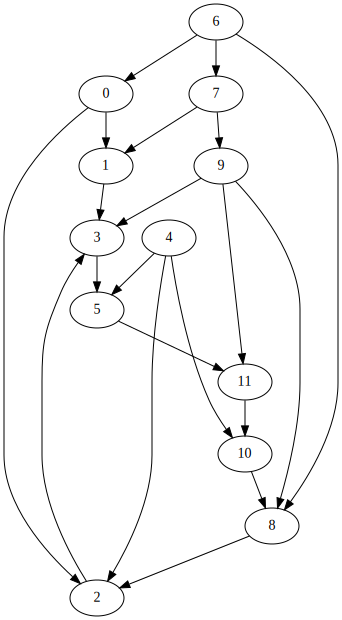

In [13]:
graphviz.Source(br_dg_64.graphviz())

## MorseDecomposition
Because domain graphs are too big, we summarize dynamics using Morse Decomposition, which is the partially ordered set of recurrent components (strongly connected components with an edge) of the domain graph.

In [14]:
br_morsedecomposition = DSGRN.MorseDecomposition(br_dg_64.digraph())

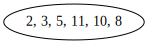

In [15]:
graphviz.Source(br_morsedecomposition.graphviz())

As you can see, this pulls out the sequence of domains that are recurrent. 

## MorseGraph
The final step in our analysis is the production of an annotated Morse graph, which summarizes how Morse sets are related to each other. In this case there is only one Morse set so the order is trivial. However, this also provides annotation of the Morse set. Annotation FC means that each variable has crossed the threshold at least once (and hence it must have at least twice) while traversing the Morse set. From the description of the Morse set above it is not clear if all variable crossed thresholds. 

In [16]:
br_morsegraph = DSGRN.MorseGraph()

In [17]:
br_morsegraph.assign(br_dg_64,br_morsedecomposition)

In [18]:
print(br_morsegraph)

{"poset":[[]],"annotations":[["FC"]]}


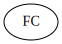

In [19]:
graphviz.Source(br_morsegraph.graphviz())

The annotation FC suggests that this Morse set contains solutions where each variable oscillates.



Now we will go back and  find a parameter node that exhibits bistability.

# There is no bistability in the parameter space!

We need to change a model. How?

I constructed a second network which I think should show bistability

In [20]:
br2 = DSGRN.Network("br2.txt")

In [21]:
print(br2)

In [22]:
graph = graphviz.Source(br2.graphviz())

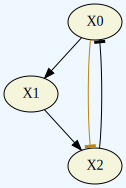

In [23]:
graph

What are the differences between this and the previous network?

Let's find the parameters where we have bistability between FP(0,1,1) and FP(2,1,0):

~~~~
sqlite3 br2.db 'select ParameterIndex from Signatures natural join (select MorseGraphIndex from (select MorseGraphIndex from MorseGraphAnnotations where Label="FP { 0, 1, 1 }") natural join (select MorseGraphIndex from MorseGraphAnnotations where Label="FP { 2, 1, 0 }"));'
~~~~


Note that all of the spaces in "FP { 2, 1, 0 }" are very important. Searches will fail without spaces.

One of the parameters in the list is parameter 141, which we will study next. Before we do that we also show that we can search for individual annotation of FP - selecting a particular equlibrium 'phenotype'

~~~~

sqlite3 br2.db 'select ParameterIndex from Signatures natural join (select MorseGraphIndex from (select MorseGraphIndex from MorseGraphAnnotations where Label="FP { 0, 1, 1 }"));'  
~~~~

In [24]:
parametergraph = DSGRN.ParameterGraph(br2)

In [25]:
br2_141=parametergraph.parameter(141)

Now we look at the domain graph

In [26]:
domaingraph_br2_141 = DSGRN.DomainGraph(br2_141)

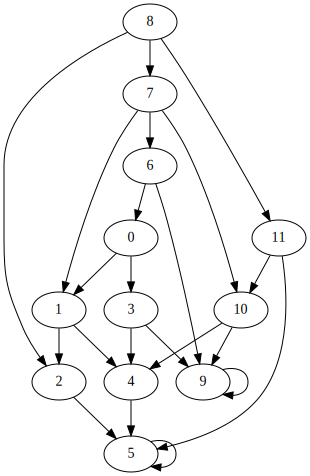

In [27]:
graphviz.Source(domaingraph_br2_141.graphviz())

Bistability is between domains 5 and 9, but in bigger graphs this would be impossible to see. We also want to recover the annotations. So we go to Morse decomposition.

In [28]:
morsedecomposition = DSGRN.MorseDecomposition(domaingraph_br2_141.digraph())

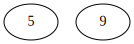

In [29]:
graphviz.Source(morsedecomposition.graphviz())

We just recovered the strongly connected components

In [30]:
morsegraph = DSGRN.MorseGraph()

In [31]:
morsegraph.assign(domaingraph_br2_141, morsedecomposition)

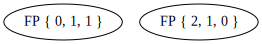

In [32]:
graphviz.Source(morsegraph.graphviz())


This recovers the information that is stored in the Database